<a href="https://colab.research.google.com/github/Danielle-Aguado/CPEN70/blob/main/Chapter_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###9.Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 451s 261ms/step - loss: 0.1672 - accuracy: 0.9491 - val_loss: 0.0414 - val_accuracy: 0.9876
Epoch 2/10
1719/1719 [==============================] - 443s 258ms/step - loss: 0.0664 - accuracy: 0.9809 - val_loss: 0.0410 - val_accuracy: 0.9882
Epoch 3/10
1719/1719 [==============================] - 437s 254ms/step - loss: 0.0505 - accuracy: 0.9846 - val_loss: 0.0388 - val_accuracy: 0.9910
Epoch 4/10
1719/1719 [==============================] - 428s 249ms/step - loss: 0.0389 - accuracy: 0.9885 - val_loss: 0.0312 - val_accuracy: 0.9918
Epoch 5/10
1719/1719 [==============================] - 428s 249ms/step - loss: 0.0337 - accuracy: 0.9895 - val_loss: 0.0293 - val_accuracy: 0.9942
Epoch 6/10
1719/1719 [==============================] - 424s 247ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0421 - val_accuracy: 0.9912
Epoch 7/10
1719/1719 [==============================] - 425s 247ms/step - loss: 0.0241 - accuracy: 0.9921 - val_

[0.030171262100338936, 0.9926000237464905]

###10. Use transfer learning for large image classification.

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('beans', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteEOVRVS/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteEOVRVS/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteEOVRVS/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [2]:
info.splits

{Split('train'): <SplitInfo num_examples=1034, num_shards=2>,
 Split('validation'): <SplitInfo num_examples=133, num_shards=1>,
 Split('test'): <SplitInfo num_examples=128, num_shards=1>}

In [3]:
info.splits["train"]

<SplitInfo num_examples=1034, num_shards=2>

In [4]:
class_names = info.features["label"].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [5]:
n_classes = info.features["label"].num_classes

In [6]:
dataset_size = info.splits["train"].num_examples
dataset_size

1034

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "beans",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

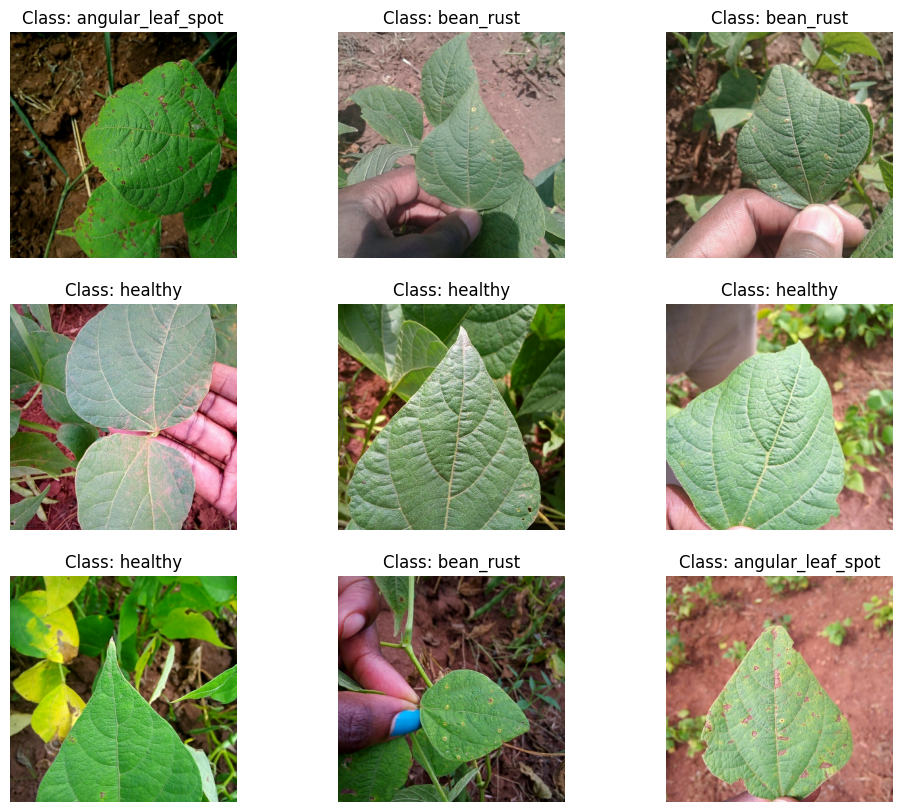

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [9]:
#Basic Preprocessing
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [10]:
import tensorflow as tf
import keras
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

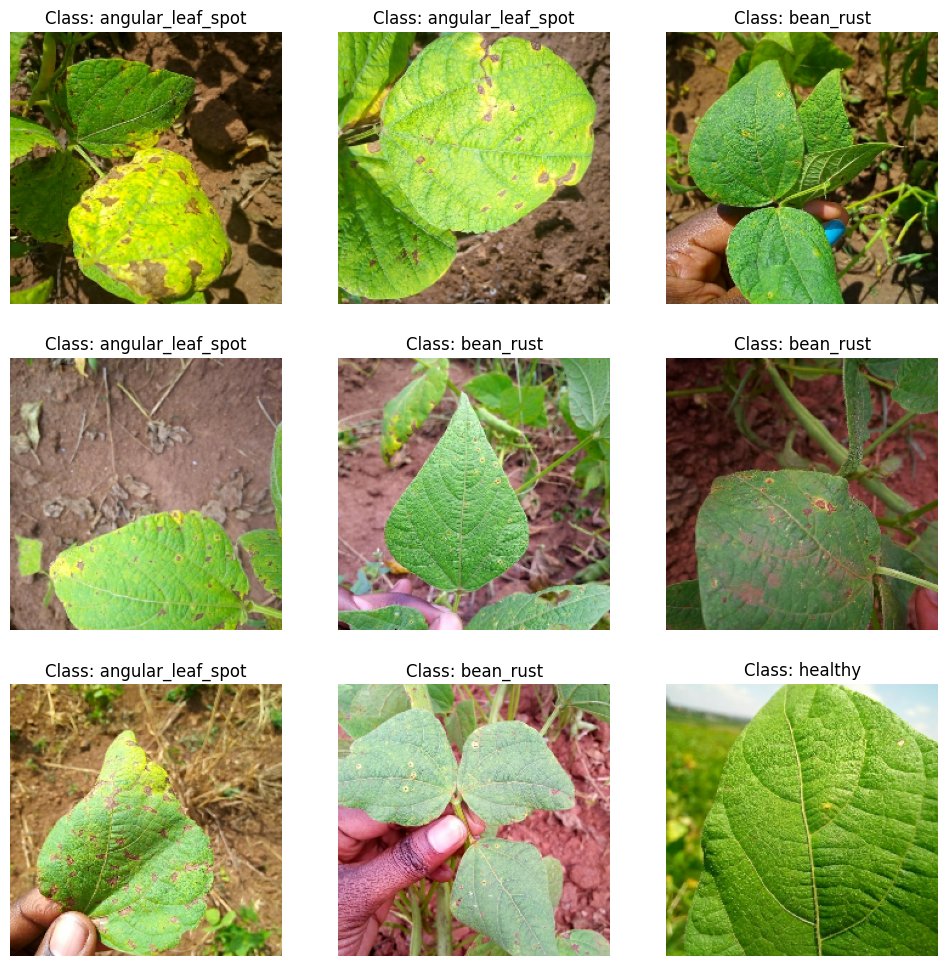

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

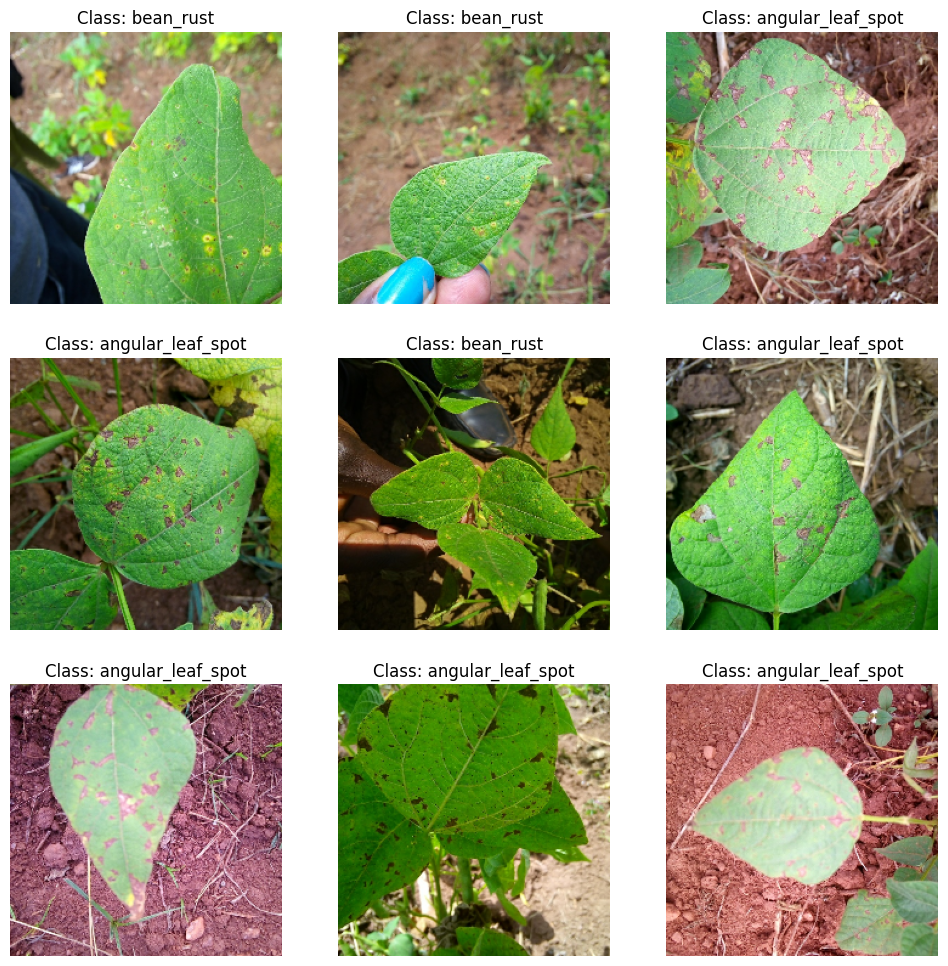

In [12]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [13]:
base_mdl = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_mdl.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_mdl.input, outputs=output)

83683744/83683744 [==============================] - 3s 0us/step


In [14]:
for index, layer in enumerate(base_mdl.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [15]:
for layer in base_mdl.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
24/24 [==============================] - 218s 9s/step - loss: 6.7267 - accuracy: 0.5443 - val_loss: 1.9051 - val_accuracy: 0.7734
Epoch 2/5
24/24 [==============================] - 214s 9s/step - loss: 2.2316 - accuracy: 0.7930 - val_loss: 1.7872 - val_accuracy: 0.8047
Epoch 3/5
24/24 [==============================] - 213s 9s/step - loss: 1.5494 - accuracy: 0.8346 - val_loss: 1.3178 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 213s 9s/step - loss: 1.6621 - accuracy: 0.8346 - val_loss: 1.7310 - val_accuracy: 0.8047
Epoch 5/5
24/24 [==============================] - 219s 9s/step - loss: 1.4088 - accuracy: 0.8346 - val_loss: 2.1468 - val_accuracy: 0.7812


In [16]:
for layer in base_mdl.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=20)

Epoch 1/20
24/24 [==============================] - 811s 33s/step - loss: 0.7281 - accuracy: 0.7891 - val_loss: 1.9598 - val_accuracy: 0.6797
Epoch 2/20
24/24 [==============================] - 781s 33s/step - loss: 0.1581 - accuracy: 0.9440 - val_loss: 1.2531 - val_accuracy: 0.7734
Epoch 3/20
24/24 [==============================] - 775s 32s/step - loss: 0.0983 - accuracy: 0.9688 - val_loss: 0.1874 - val_accuracy: 0.9219
Epoch 4/20
24/24 [==============================] - 768s 32s/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 0.1654 - val_accuracy: 0.9375
Epoch 5/20
24/24 [==============================] - 757s 32s/step - loss: 0.0103 - accuracy: 0.9987 - val_loss: 0.1483 - val_accuracy: 0.9453
Epoch 6/20
24/24 [==============================] - 781s 33s/step - loss: 0.0531 - accuracy: 0.9792 - val_loss: 0.2168 - val_accuracy: 0.9375
Epoch 7/20
24/24 [==============================] - 778s 32s/step - loss: 0.0524 - accuracy: 0.9883 - val_loss: 0.1648 - val_accuracy: 0.9531
Epoch 

###11. Generate art using Deep Learning

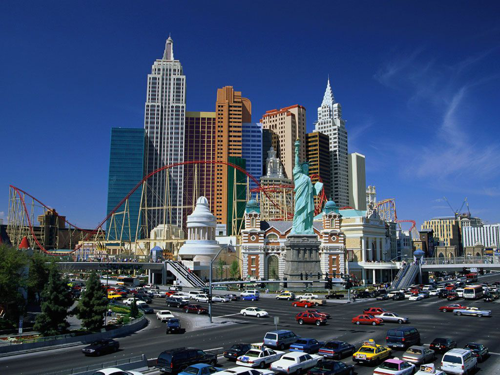

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

#Image of a city
url = "https://th.bing.com/th/id/R.7dd214b573656611f73080f51fa18015?rik=kwB6%2bcBsKUPCag&riu=http%3a%2f%2fwww.zastavki.com%2fpictures%2f1366x768%2f2007%2fCities__003946_.jpg&ehk=%2fFCz%2fwa29giFdfjLfnxnjR63dLYfXw7QcUZ7DcRECzY%3d&risl=&pid=ImgRaw&r=0"

#Download an image and read it into a NumPy array
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

#Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

#Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


#Downsizing the image makes it easier to work with
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://www.conservator.ca/assets/2015/02/owl-jeope-wolfe-780x520.jpg">Jeope Wolfe</a>'))

In [ ]:
#Prepare feature extraction model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
#Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

#Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
#Calculate loss - loss is the sum of the activations in the chosen layers
def calc_loss(img, model):
  #Pass forward the image through the model to retrieve the activations.
  #Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
#Calculate gradients with respect to the image, and add them to the original image
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          #This needs gradients relative to `img`
          #GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        #Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        #Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        #In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        #You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
#Main loop
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  #Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

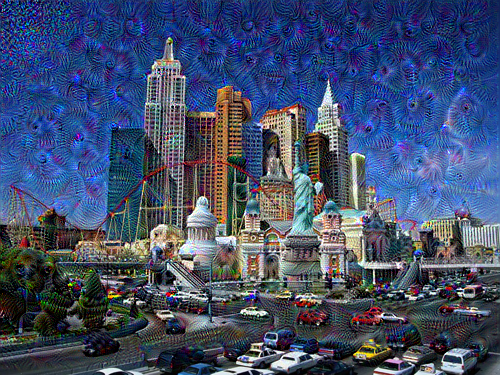

In [ ]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)

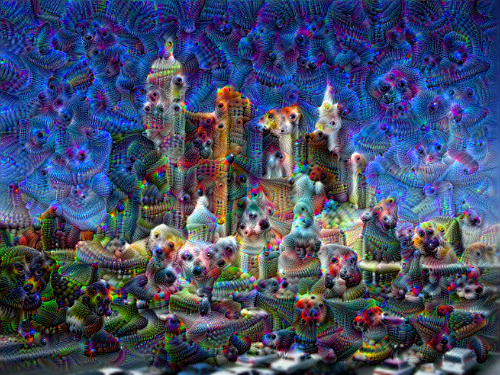

310.1132960319519

In [ ]:
#Taking it up an octave
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [ ]:
#Scaling up with tiles (Optional)
#Implementing random shift

def random_roll(img, maxroll):
  #Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

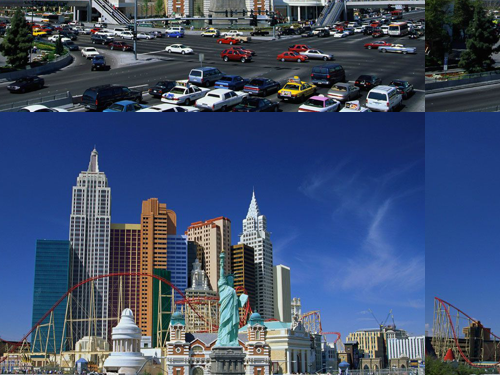

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
#Tiled equivalent of the Deep Dream function
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    #Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    #Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        #Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          #This needs gradients relative to `img_rolled`.
          #`GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          #Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        #Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    #Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    #Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

In [ ]:
#Octave-aware deepdream implementation
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    #Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

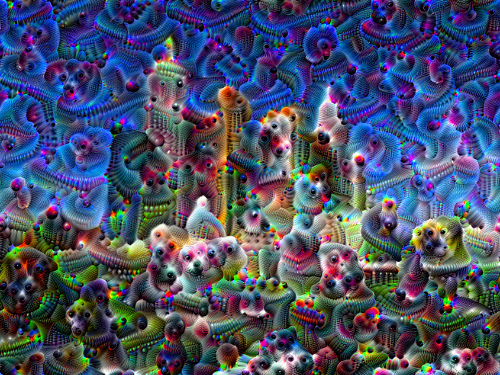

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)